In [149]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

In [150]:
class DataCloud:
	N=0
	def __init__(self,x):
		self.n=1
		self.mean=x
		self.variance=0
		self.pertinency=1
		DataCloud.N+=1
	def addDataClaud(self,x):
		self.n=2
		self.mean=(self.mean+x)/2
		self.variance=((np.linalg.norm(self.mean-x))**2)
	def updateDataCloud(self,n,mean,variance):
		self.n=n
		self.mean=mean
		self.variance=variance

Replacement of equation $[[\sigma^2]_{k}^{i}]^{'}= \frac{k - 1}{k}[\sigma^2]_{k-1}^{i} + \frac{1}{k} \Vert x_k - [\mu_{k}^{i}]^{'} \Vert
$ by $[[\sigma^2]_{k}^{i}]^{'}= \frac{k - 1}{k}[\sigma^2]_{k-1}^{i} + \frac{1}{k-1} \Vert x_k - [\mu_{k}^{i}]^{'} \Vert
$






In [151]:
class AutoCloud:
	c= np.array([DataCloud(0)],dtype=DataCloud)
	alfa= np.array([0.0],dtype=float)
	intersection = np.zeros((1,1),dtype=int)
	listIntersection = np.zeros((1),dtype=int)
	matrixIntersection = np.zeros((1,1),dtype=int)
	relevanceList = np.zeros((1),dtype=int)
	k=1
	def __init__(self, m):
		AutoCloud.m = m
		AutoCloud.c = np.array([DataCloud(0)],dtype=DataCloud)
		AutoCloud.alfa= np.array([0.0],dtype=float)
		AutoCloud.intersection = np.zeros((1,1),dtype=int)
		AutoCloud.listIntersection = np.zeros((1),dtype=int)
		AutoCloud.relevanceList = np.zeros((1),dtype=int)
		AutoCloud.matrixIntersection = np.zeros((1,1),dtype=int)
		AutoCloud.k=1
		AutoCloud.classIndex = [[1.0],[1.0]]
		AutoCloud.listEccentricity = []
		AutoCloud.listTypicality = []
		AutoCloud.listNormEccentricity = []
		AutoCloud.listNormTypicality = []
		AutoCloud.argMax = []
    		

	def mergeClouds(self):
		i=0
		while(i<len(AutoCloud.listIntersection)-1):
			merge=False
			j=i+1
			while(j<len(AutoCloud.listIntersection)):
				#print("i",i,"j",j,"l",np.size(AutoCloud.listIntersection),"m",np.size(AutoCloud.matrixIntersection),"c",np.size(AutoCloud.c))
				if(AutoCloud.listIntersection[i] == 1 and AutoCloud.listIntersection[j] == 1):
					AutoCloud.matrixIntersection[i,j] = AutoCloud.matrixIntersection[i,j] + 1;
				nI = AutoCloud.c[i].n
				nJ = AutoCloud.c[j].n
				meanI = AutoCloud.c[i].mean
				meanJ = AutoCloud.c[j].mean
				varianceI = AutoCloud.c[i].variance
				varianceJ = AutoCloud.c[j].variance
				nIntersc = AutoCloud.matrixIntersection[i,j]
				if (nIntersc > (nI - nIntersc) or nIntersc > (nJ - nIntersc)):
					merge = True
					#update values
					n = nI + nJ - nIntersc
					mean = ((nI * meanI) + (nJ * meanJ))/(nI + nJ)
					variance = ((nI - 1) * varianceI + (nJ - 1) * varianceJ)/(nI + nJ - 2)
					newCloud = DataCloud(mean)
					newCloud.updateDataCloud(n,mean,variance)
					#atualizando lista de interseção
					AutoCloud.listIntersection = np.concatenate((AutoCloud.listIntersection[0 : i], np.array([1]), AutoCloud.listIntersection[i + 1 : j],AutoCloud.listIntersection[j + 1 : np.size(AutoCloud.listIntersection)]),axis=None)
					#atualizando lista de data clouds 
					AutoCloud.c = np.concatenate((AutoCloud.c[0 : i ], np.array([newCloud]), AutoCloud.c[i + 1 : j],AutoCloud.c[j + 1 : np.size(AutoCloud.c)]),axis=None)
					#update  intersection matrix
					M0 = AutoCloud.matrixIntersection
					#Remover linhas 
					M1=np.concatenate((M0[0 : i , :],np.zeros((1,len(M0))),M0[i + 1 : j, :],M0[j + 1 : len(M0), :]))
					#remover colunas
					M1=np.concatenate((M1[:, 0 : i ],np.zeros((len(M1),1)),M1[:, i+1 : j],M1[:, j+1 : len(M0)]),axis=1)
					#calculando nova coluna
					col = (M0[:, i] + M0[:, j])*(M0[: , i]*M0[:, j] != 0)
					col = np.concatenate((col[0 : j], col[j + 1 : np.size(col)]))
					#calculando nova linha
					lin = (M0[i, :]+M0[j, :])*(M0[i, :]*M0[j, :] != 0)
					lin = np.concatenate((lin[ 0 : j], lin[j + 1 : np.size(lin)]))
					#atualizando coluna
					M1[:,i]=col
					#atualizando linha
					M1[i,:]=lin
					M1[i, i + 1 : j] = M0[i, i + 1 : j] + M0[i + 1 : j, j].T;   
					AutoCloud.matrixIntersection = M1
				j += 1
			if(merge):
				i = 0
			else:
				i += 1
				
	def run(self,X):
		AutoCloud.listIntersection = np.zeros((np.size(AutoCloud.c)),dtype=int)
		if AutoCloud.k==1:
			AutoCloud.c[0]=DataCloud(X)
			AutoCloud.argMax.append(0)
		elif AutoCloud.k==2:
			AutoCloud.c[0].addDataClaud(X)
			AutoCloud.argMax.append(0)
		elif AutoCloud.k>=3:
			i=0
			createCloud = True
			AutoCloud.alfa = np.zeros((np.size(AutoCloud.c)),dtype=float)
			for data in AutoCloud.c:
				n = data.n + 1
				mean = ((n-1)/n)*data.mean + (1/n)*X
				variance = ((n-1)/n)*data.variance +(1/(n-1))*((np.linalg.norm(X-mean))**2)
				eccentricity=(1/n)+((mean-X).T.dot(mean-X))/(n*variance)
				norm_eccentricity = eccentricity/2
				typicality = 1 - eccentricity
				norm_typicality = typicality/(AutoCloud.k-2)
				AutoCloud.listEccentricity.append(eccentricity)
				AutoCloud.listTypicality.append(typicality)
				AutoCloud.listNormEccentricity.append(norm_eccentricity)
				AutoCloud.listNormTypicality.append(norm_typicality)
				if(norm_eccentricity<=(AutoCloud.m**2 +1)/(2*n)):
					data.updateDataCloud(n,mean,variance)
					AutoCloud.alfa[i] = norm_typicality
					createCloud= False
					AutoCloud.listIntersection.itemset(i,1)
				else:
					AutoCloud.alfa[i] = norm_typicality
					AutoCloud.listIntersection.itemset(i,0)
				i+=1
			
			if(createCloud):
				AutoCloud.c = np.append(AutoCloud.c,DataCloud(X))
				AutoCloud.listIntersection = np.insert(AutoCloud.listIntersection,i,1)
				AutoCloud.matrixIntersection = np.pad(AutoCloud.matrixIntersection, ((0,1),(0,1)), 'constant', constant_values=(0)) 
			self.mergeClouds()
			AutoCloud.relevanceList = AutoCloud.alfa /np.sum(AutoCloud.alfa)
			AutoCloud.argMax.append(np.argmax(AutoCloud.relevanceList))
			AutoCloud.classIndex.append(AutoCloud.alfa) 

        
		AutoCloud.k=AutoCloud.k+1

In [152]:
def Dmin(c):
	dmin = np.linalg.norm(np.subtract(c[0].mean,c[1].mean))
	for i in range(len(c)):
		for j in range(len(c)): 
			if(i != j):
				if(np.linalg.norm(np.subtract(c[i].mean,c[j].mean))<dmin):
					dmin = np.linalg.norm(np.subtract(c[i].mean,c[j].mean))
	return dmin

##S1

In [153]:
!wget https://raw.githubusercontent.com/deric/clustering-benchmark/master/src/main/resources/datasets/artificial/s-set1.arff

--2022-06-14 11:03:30--  https://raw.githubusercontent.com/deric/clustering-benchmark/master/src/main/resources/datasets/artificial/s-set1.arff
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 102051 (100K) [text/plain]
Saving to: ‘s-set1.arff.2’

s-set1.arff.2       100%[===================>]  99.66K  --.-KB/s    in 0.01s   

2022-06-14 11:03:30 (7.02 MB/s) - ‘s-set1.arff.2’ saved [102051/102051]



In [154]:
from scipy.io import arff

data = arff.loadarff('s-set1.arff')
df = pd.DataFrame(data[0])
df.CLASS = df.CLASS.astype(int)

In [155]:
centroides_s1 = pd.read_csv('centroides_s1.csv')
c_s1 = np.array([centroides_s1["1"],centroides_s1["2"]])

In [156]:
dados = np.array([df["x"],df["y"]])

In [157]:
dados= dados.T
test=AutoCloud(2)
for t in dados:
    test.run(np.array(t))



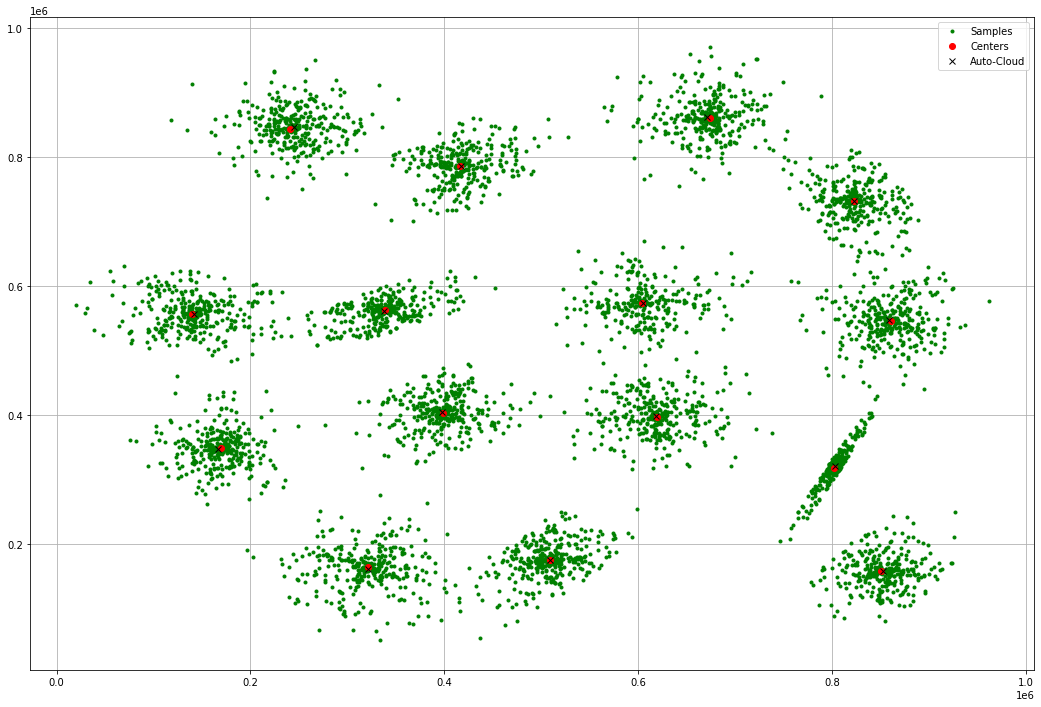

In [158]:
plt.rcParams["figure.figsize"] = (18,12)
plt.grid()
dados= dados.T
plt.plot(dados[0],dados[1],'.g')
plt.plot(c_s1[0],c_s1[1],'or')
for i in range(0,np.size(test.c)):
    plt.plot(test.c[i].mean[0],test.c[i].mean[1],'x',color='black')
plt.legend(['Samples','Centers','Auto-Cloud'])    
plt.show()

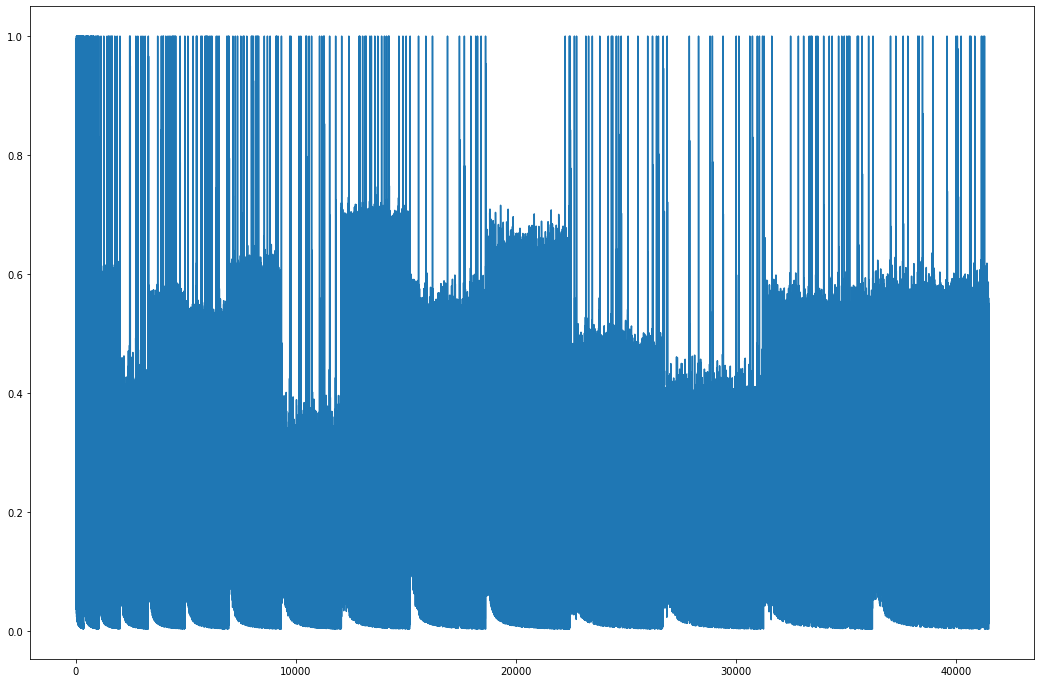

In [159]:
plt.plot(test.listEccentricity)

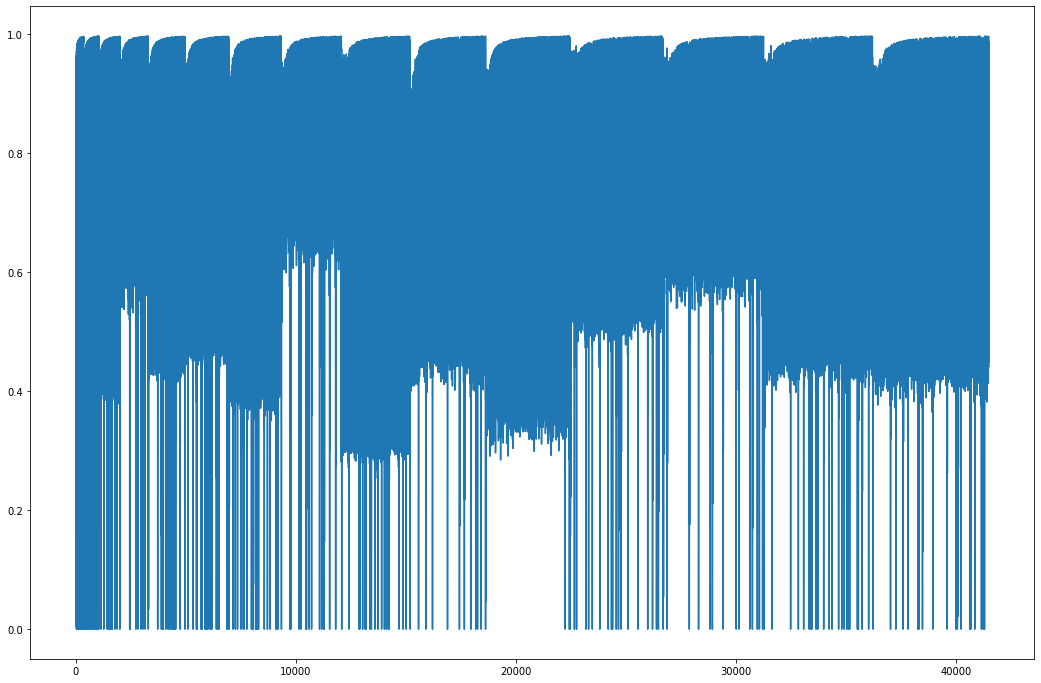

In [160]:
plt.plot(test.listTypicality)

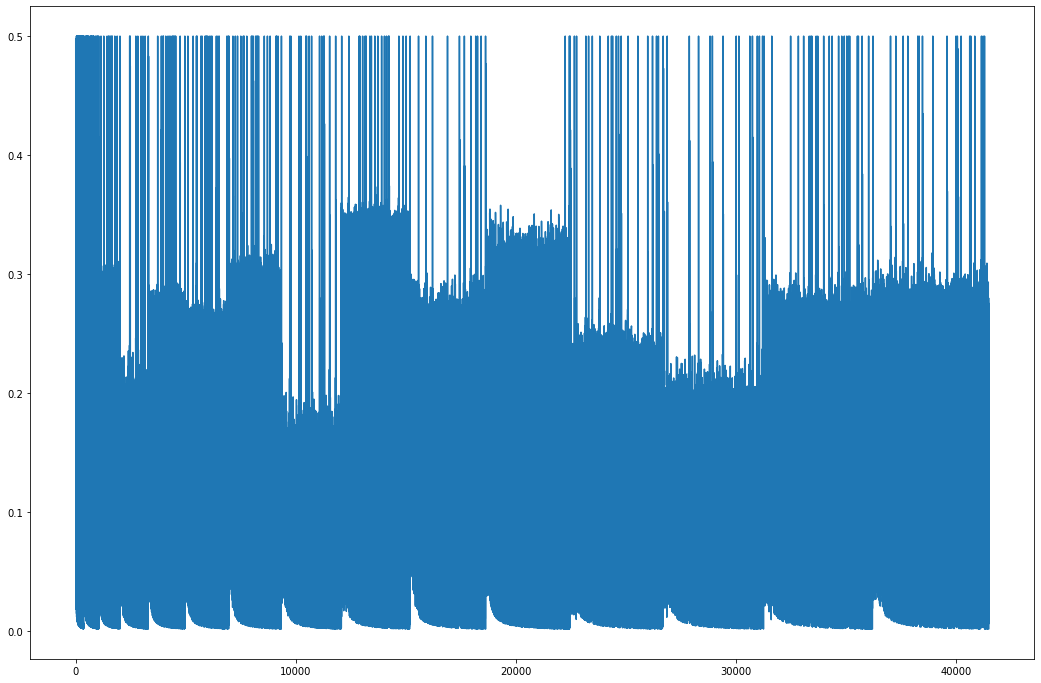

In [161]:
plt.plot(test.listNormEccentricity)

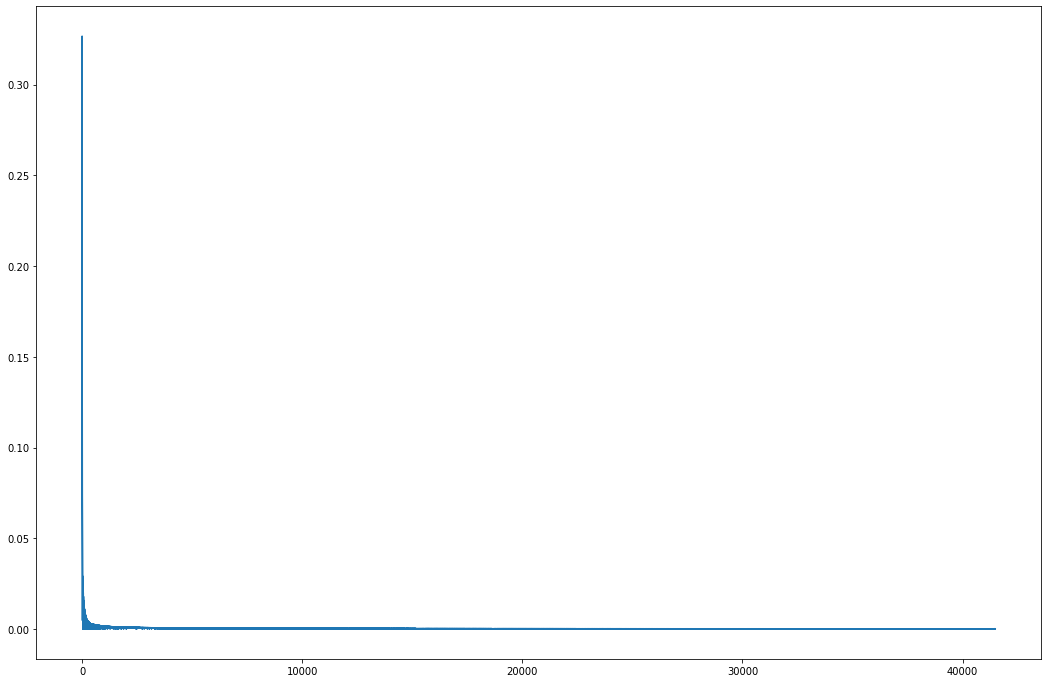

In [162]:
plt.plot(test.listNormTypicality)

## Quality 

In [163]:
for i in range(len(test.classIndex)):
  test.classIndex[i] = test.classIndex[i]/np.sum(test.classIndex[i])

In [164]:
dmin = Dmin(test.c)
N = len(dados.T)
classIndex  = np.asarray(test.classIndex)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until


In [165]:
sum = 0.0
for i in range(len(test.c)):
  for j in range(N):
    mi = 0
    if(i<len(classIndex[j])):
      mi = classIndex[j][i]
    sum = sum + (mi*mi)*np.linalg.norm(test.c[i].mean - dados.T[j])

In [166]:
sum/(N*dmin)

0.2593189555180972

#Accuracy

In [167]:
from sklearn.metrics import accuracy_score

In [168]:
accuracy_score(df["CLASS"],AutoCloud.argMax)

0.1226

#Adjusted Rand Score

In [169]:
from sklearn import metrics, cluster
metrics.adjusted_rand_score(df["CLASS"],AutoCloud.argMax)

0.8543636517844607

#Adjusted Mutual Information (AMI)

In [170]:
metrics.normalized_mutual_info_score(df["CLASS"],AutoCloud.argMax)

0.8976146725915028

In [171]:
metrics.adjusted_mutual_info_score(df["CLASS"],AutoCloud.argMax)

0.8968609194778963

#Purity

In [172]:
def purity(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)

    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

In [173]:
purity(df["CLASS"],AutoCloud.argMax)

0.9284

##S2


In [174]:
centroides_s2 = pd.read_csv('centroides_s2.csv')
c_s2 = np.array([centroides_s2["1"],centroides_s2["2"]])

In [175]:
data = pd.read_csv('s2.csv')
dados = np.array([data["1"],data["2"]])

In [176]:
dados= dados.T
teste=AutoCloud(2)
for t in dados:
    teste.run(np.array(t))



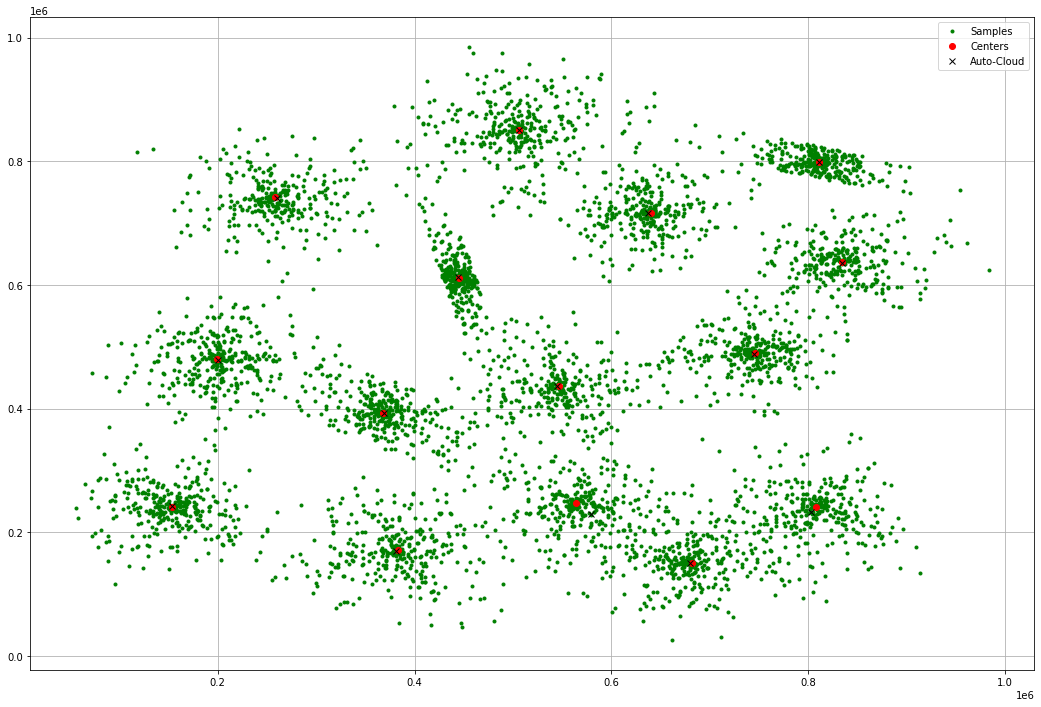

In [177]:
plt.rcParams["figure.figsize"] = (18,12)
plt.grid()
dados= dados.T
plt.plot(dados[0],dados[1],'.g')
plt.plot(c_s2[0],c_s2[1],'or')
for i in range(0,np.size(teste.c)):
    plt.plot(teste.c[i].mean[0],teste.c[i].mean[1],'x',color='black')
plt.legend(['Samples','Centers','Auto-Cloud'])    
plt.show()

## Quality 

In [178]:
for i in range(len(teste.classIndex)):
  teste.classIndex[i] = teste.classIndex[i]/np.sum(teste.classIndex[i])

In [179]:
dmin = Dmin(teste.c)
N = len(dados.T)
classIndex  = np.asarray(teste.classIndex)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until


In [180]:
sum = 0
for i in range(len(teste.c)):
  for j in range(N):
    mi = 0
    if(i<len(classIndex[j])):
      mi = classIndex[j][i]
    sum = sum + (mi*mi) *np.linalg.norm(teste.c[i].mean - dados.T[j])

In [181]:
sum/(N*dmin)

0.3658113890386763

##A1

In [182]:
centroides_a1 = pd.read_csv('centroides_a1.csv')
c_a1 = np.array([centroides_a1["1"],centroides_a1["2"]])

In [183]:
data = pd.read_csv('a1.csv')
dados = np.array([data["1"],data["2"]])

In [184]:
dados= dados.T
teste=AutoCloud(2)
for t in dados:
    teste.run(np.array(t))



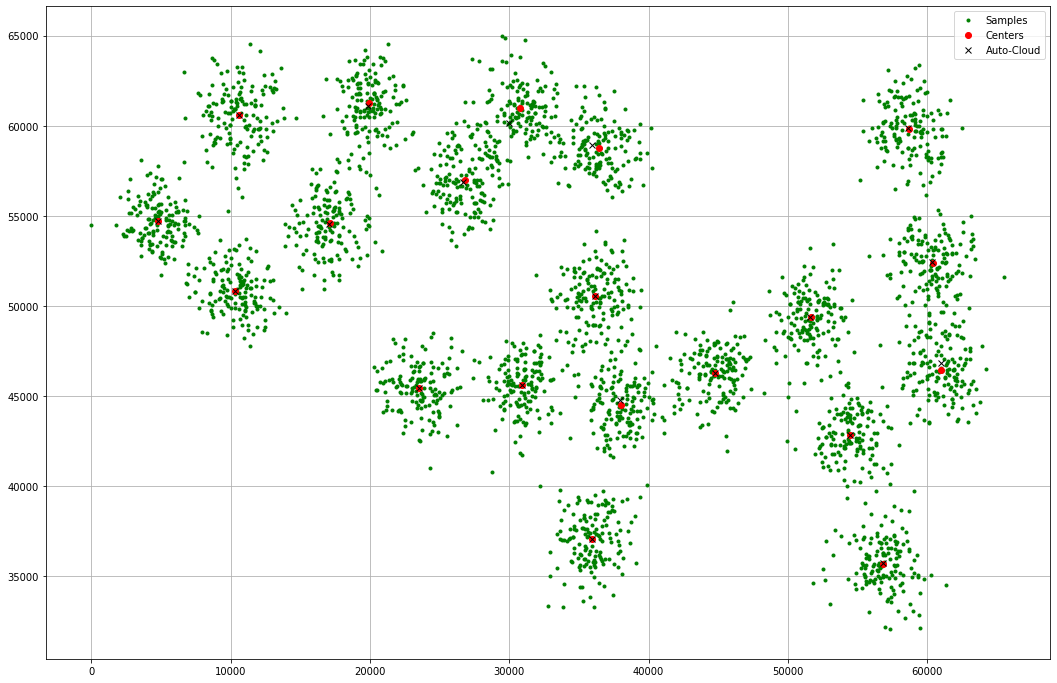

In [185]:
plt.rcParams["figure.figsize"] = (18,12)
plt.grid()
dados= dados.T
plt.plot(dados[0],dados[1],'.g')
plt.plot(c_a1[0],c_a1[1],'or')
for i in range(0,np.size(teste.c)):
    plt.plot(teste.c[i].mean[0],teste.c[i].mean[1],'x',color='black')
plt.legend(['Samples','Centers','Auto-Cloud'])    
plt.show()

## Quality 

In [186]:
for i in range(len(teste.classIndex)):
  teste.classIndex[i] = teste.classIndex[i]/np.sum(teste.classIndex[i])

In [187]:
dmin = Dmin(teste.c)
N = len(dados.T)
classIndex  = np.asarray(teste.classIndex)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until


In [188]:
sum = 0
for i in range(len(teste.c)):
  for j in range(N):
    mi = 0
    if(i<len(classIndex[j])):
      mi = classIndex[j][i]
    sum = sum + (mi*mi) *np.linalg.norm(teste.c[i].mean - dados.T[j])

In [189]:
sum/(N*dmin)

0.31890727924717294

##A2

In [190]:
centroides_a2 = pd.read_csv('centroides_a2.csv')
c_a2 = np.array([centroides_a2["1"],centroides_a2["2"]])

In [191]:
data = pd.read_csv('a2.csv')
dados = np.array([data["1"],data["2"]])

In [192]:
dados= dados.T
teste=AutoCloud(2)
for t in dados:
    teste.run(np.array(t))



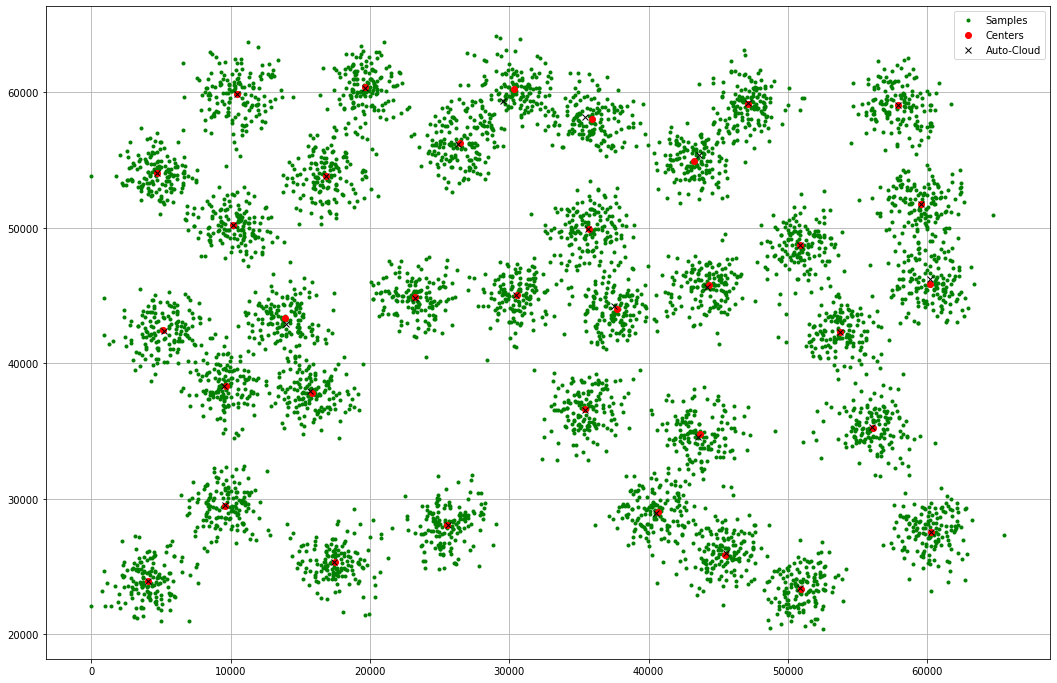

In [193]:
plt.rcParams["figure.figsize"] = (18,12)
plt.grid()
dados= dados.T
plt.plot(dados[0],dados[1],'.g')
plt.plot(c_a2[0],c_a2[1],'or')
for i in range(0,np.size(teste.c)):
    plt.plot(teste.c[i].mean[0],teste.c[i].mean[1],'x',color='black')
plt.legend(['Samples','Centers','Auto-Cloud'])    
plt.show()

## Quality 

In [194]:
for i in range(len(teste.classIndex)):
  teste.classIndex[i] = teste.classIndex[i]/np.sum(teste.classIndex[i])

In [195]:
dmin = Dmin(teste.c)
N = len(dados.T)
classIndex  = np.asarray(teste.classIndex)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until


In [196]:
sum = 0
for i in range(len(teste.c)):
  for j in range(N):
    mi = 0
    if(i<len(classIndex[j])):
      mi = classIndex[j][i]
    sum = sum + (mi*mi) *np.linalg.norm(teste.c[i].mean - dados.T[j])

In [197]:
sum/(N*dmin)

0.2556974511133556

##Compound

In [198]:
centroides_c = pd.read_csv('centrosCompound.csv')
c_c = np.array([centroides_c["1"],centroides_c["2"]])

In [199]:
data = pd.read_csv('Compound.csv')
dados = np.array([data["1"],data["2"]])

In [200]:
dados= dados.T
teste=AutoCloud(2)
for t in dados:
    teste.run(np.array(t))



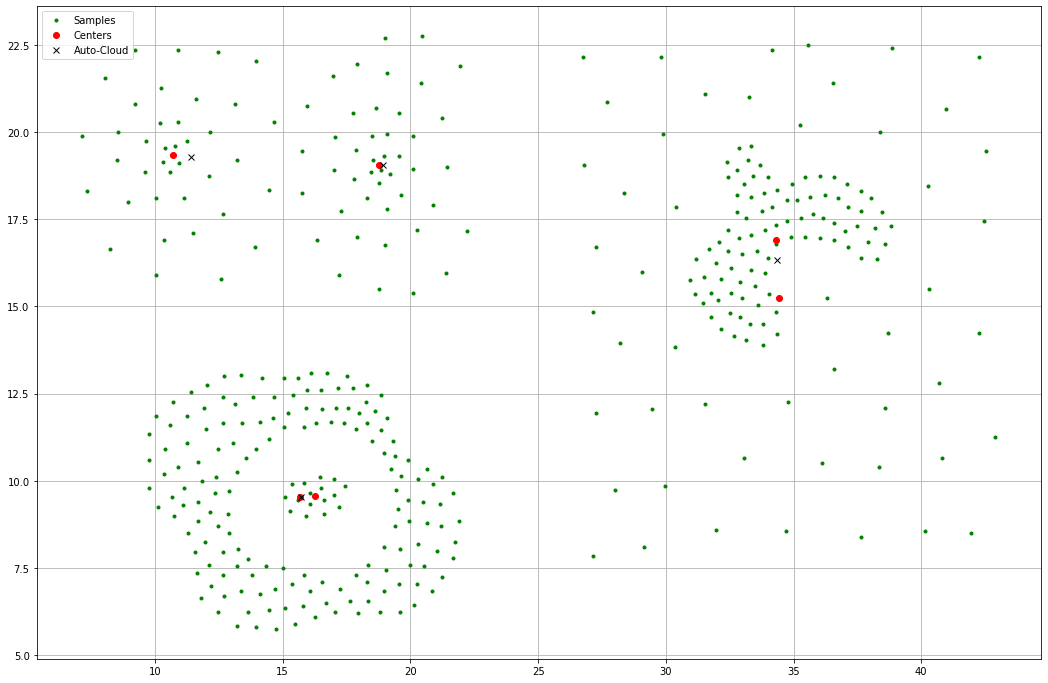

In [201]:
plt.rcParams["figure.figsize"] = (18,12)
plt.grid()
dados= dados.T
plt.plot(dados[0],dados[1],'.g')
plt.plot(c_c[0],c_c[1],'or')
for i in range(0,np.size(teste.c)):
    plt.plot(teste.c[i].mean[0],teste.c[i].mean[1],'x',color='black')
plt.legend(['Samples','Centers','Auto-Cloud'])    
plt.show()

## Quality 

In [202]:
for i in range(len(teste.classIndex)):
  teste.classIndex[i] = teste.classIndex[i]/np.sum(teste.classIndex[i])

In [203]:
dmin = Dmin(teste.c)
N = len(dados.T)
classIndex  = np.asarray(teste.classIndex)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until


In [204]:
sum = 0
for i in range(len(teste.c)):
  for j in range(N):
    mi = 0
    if(i<len(classIndex[j])):
      mi = classIndex[j][i]
    sum = sum + (mi*mi) *np.linalg.norm(teste.c[i].mean - dados.T[j])

In [205]:
sum/(N*dmin)

0.5019278124926903

##Unbalance

In [206]:
centroides_u = pd.read_csv('unbalance_centros.csv')
c_u = np.array([centroides_u["1"],centroides_u["2"]])

In [207]:
data = pd.read_csv('Unbalance.csv')
dados = np.array([data["1"],data["2"]])

In [208]:
dados= dados.T
teste=AutoCloud(2)
for t in dados:
    teste.run(np.array(t))



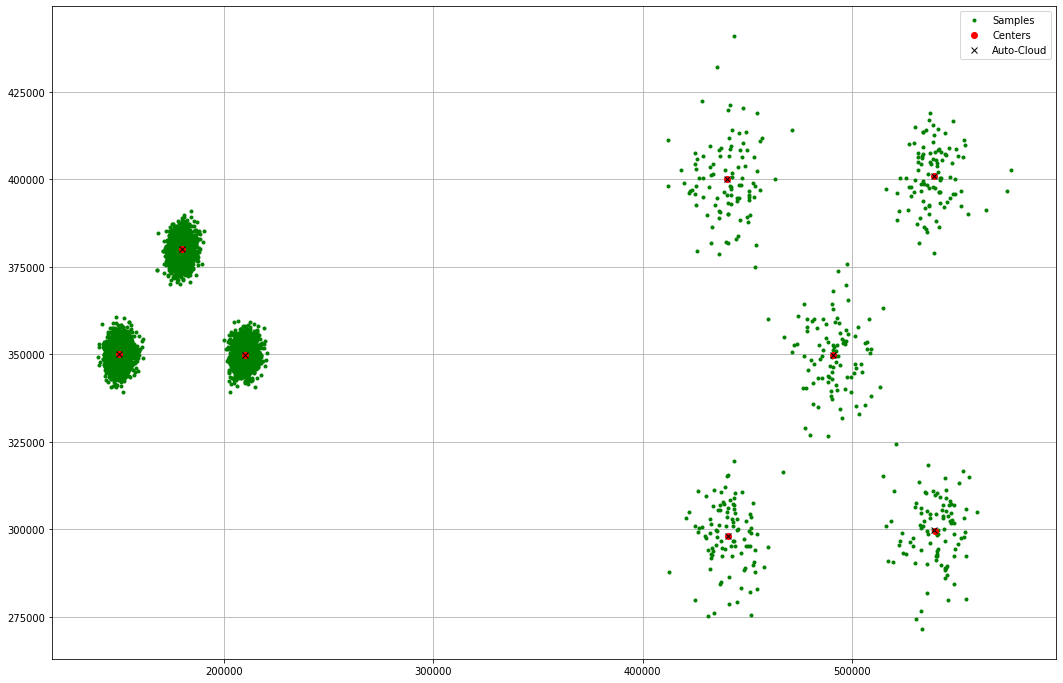

In [209]:
plt.rcParams["figure.figsize"] = (18,12)
plt.grid()
dados= dados.T
plt.plot(dados[0],dados[1],'.g')
plt.plot(c_u[0],c_u[1],'or')
for i in range(0,np.size(teste.c)):
    plt.plot(teste.c[i].mean[0],teste.c[i].mean[1],'x',color='black')
plt.legend(['Samples','Centers','Auto-Cloud'])    
plt.show()

## Quality 

In [210]:
for i in range(len(teste.classIndex)):
  teste.classIndex[i] = teste.classIndex[i]/np.sum(teste.classIndex[i])

In [211]:
dmin = Dmin(teste.c)
N = len(dados.T)
classIndex  = np.asarray(teste.classIndex)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until


In [212]:
sum = 0
for i in range(len(teste.c)):
  for j in range(N):
    mi = 0
    if(i<len(classIndex[j])):
      mi = classIndex[j][i]
    sum = sum + (mi*mi) *np.linalg.norm(teste.c[i].mean - dados.T[j])

In [213]:
sum/(N*dmin)

0.22781674401816046

##Aggregation

In [214]:
centroides_a = pd.read_csv('Aggregation_centros.csv')
c_a = np.array([centroides_a["1"],centroides_a["2"]])

In [215]:
data = pd.read_csv('Aggregation.csv')
dados = np.array([data["1"],data["2"]])

In [216]:
dados= dados.T
teste=AutoCloud(2)
for t in dados:
    teste.run(np.array(t))



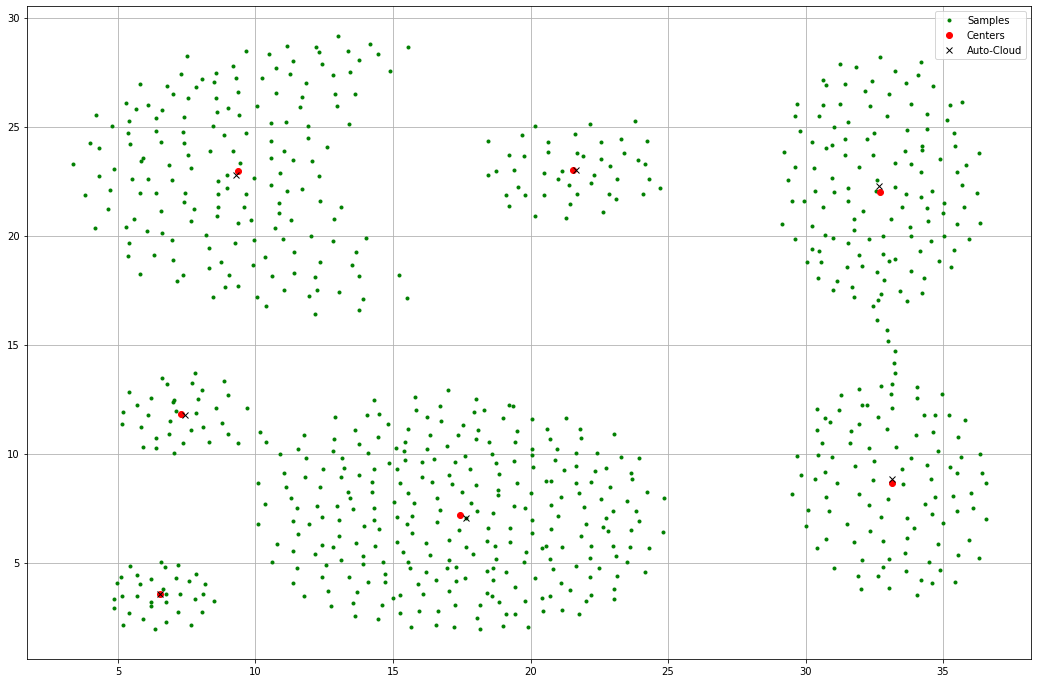

In [217]:
plt.rcParams["figure.figsize"] = (18,12)
plt.grid()
dados= dados.T
plt.plot(dados[0],dados[1],'.g')
plt.plot(c_a[0],c_a[1],'or')
for i in range(0,np.size(teste.c)):
    plt.plot(teste.c[i].mean[0],teste.c[i].mean[1],'x',color='black')
plt.legend(['Samples','Centers','Auto-Cloud'])    
plt.show()

## Quality 

In [218]:
for i in range(len(teste.classIndex)):
  teste.classIndex[i] = teste.classIndex[i]/np.sum(teste.classIndex[i])

In [219]:
dmin = Dmin(teste.c)
N = len(dados.T)
classIndex  = np.asarray(teste.classIndex)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until


In [220]:
sum = 0
for i in range(len(teste.c)):
  for j in range(N):
    mi = 0
    if(i<len(classIndex[j])):
      mi = classIndex[j][i]
    sum = sum + (mi*mi) *np.linalg.norm(teste.c[i].mean - dados.T[j])

In [221]:
sum/(N*dmin)

0.4638420256135407